Showing how to create the blue/red circle boundary as input to the hough circle method. Decided to use cuts in HSV space rather than doing RGB channel subtractions because it worked better and also more intuitive to do optimisations in HSV space. Ended up using a kernel of size 10 to dilate blue (below). This ensured circle is big enough to get a good Hough accumulator value (but any bigger introduces unnecessary noise).

In [1]:
import os                                                                      
import sys                                                                     
import datetime                                                                
import time                                                                    
                                                                               
import cv2                                                                     
import cv2.cv as cv                                                            
import numpy as np                                                             
import pandas as pd                                                            
from skimage.draw import circle_perimeter                                      
from skimage.transform import hough_circle                                     
from skimage.feature import peak_local_max, canny                              
                                                                                
import sign_detection.features.detector as detector                            
from sign_detection.data.video_handler import VideoHandler
                                                                               
display_images = False # display images as they are looped through              
save_important_images = True                                                   
save_all_images = False                                                        
save_crops = True                                                              
do_basic_selection = True                                                      
hough_radii_increment = 4                                                      
frame_increment = 4                                                            
hough_radii_tups = [(25,150), (40,200)] #garmin/canon radii limits             
                                                                               
#To run on sequential frames:                                                  
#NOTE: no gpx data available before frame 1000                                 
#frame_i = 5548                                                                
#frame_f = 5548                                                                
#frames = range(frame_i, frame_f+1, frame_increment)                           
                                                                               
# define sync variables for both videos                                        
sync_time = datetime.datetime(2017, 3, 8, 12, 16, 25)                          
sync_frame_base = 14433                                                        
fps = 24. * 1000/1001                                                          
gpxpath = "../data/raw/170308/gps/170308.GPX"

#set up video handlers for canon videos                                        
videopaths = [                                                                 
        "../data/raw/170308/video/canon/MVI_1482.MOV",
        "../data/raw/170308/video/canon/MVI_1483.MOV",
        "../data/raw/170308/video/canon/MVI_1484.MOV"]
start_frames = np.array([246, 18287, 31616])                                   
lengths = np.array([17521, 13250, 7678])                                       
end_frames = start_frames + lengths - 1                                        
frame_limits = []                                                              
for i, f in zip(start_frames, end_frames):                                     
    frame_limits.append((i,f))                                                 
print "canon frame_limits:"                                                    
print frame_limits                                                             
canon_handlers = []                                                            
for path, frame_limits in zip(videopaths, frame_limits):                       
    sync_frame = sync_frame_base - frame_limits[0]                             
    sync_tup = (sync_frame, sync_time)                                         
    canon_handlers.append(VideoHandler(path, fps, gpxpath, sync_tup, frame_limits))

canon frame_limits:
[(246, 17766), (18287, 31536), (31616, 39293)]


In [1]:
from sign_detection.data.video_handler import VideoHandler  
video_dir = "../data/raw/170308/video"
gps_path = "../data/raw/170308/gps/170308.GPX"
canon_handlers = VideoHandler.handlers_from_config(video_dir, "canon_config.csv", gps_path) 

In [2]:
base_frame = 1700
vh = canon_handlers[0]
img = vh.get_frame(base_frame)  

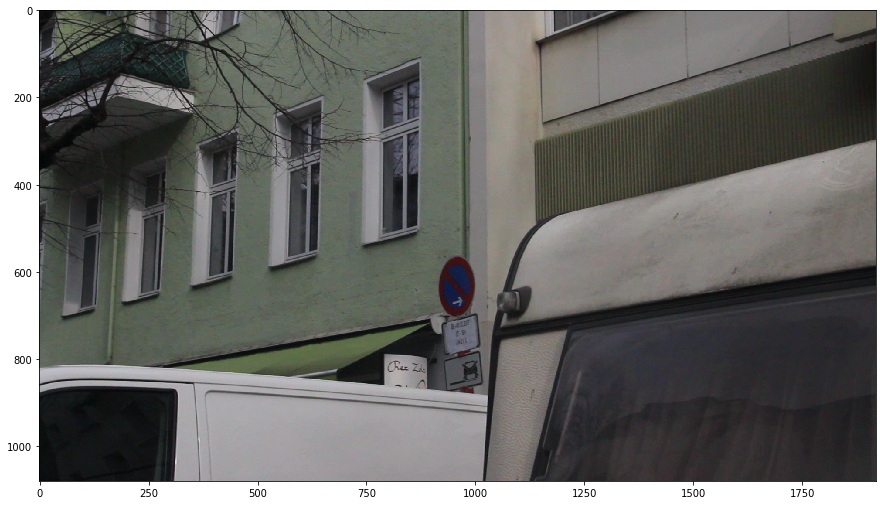

In [4]:
#plot RGB
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

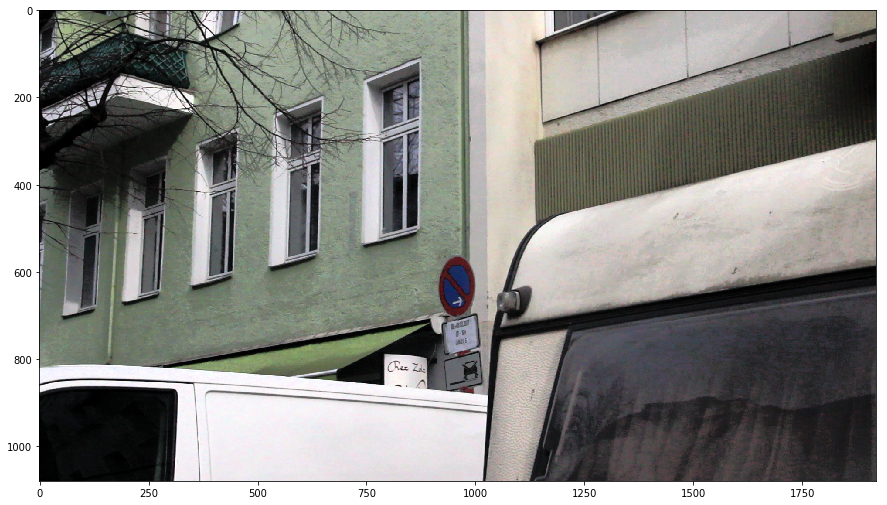

In [6]:
#equalise
import sign_detection.features.detector as detector 
img = detector.equalise_value(img)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

[  0 255]


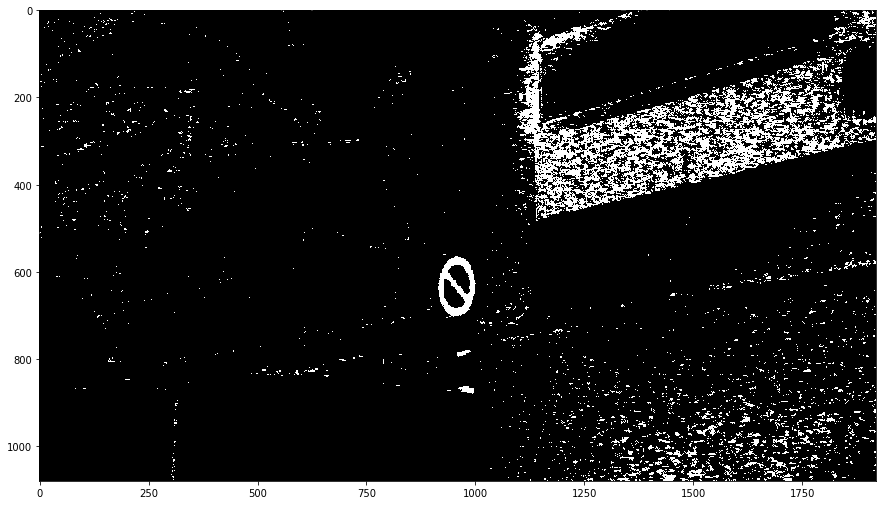

In [8]:
#red with HSV thresholds
import numpy as np
red = detector.get_red_image(img)
plt.figure(figsize=(15, 10))
plt.imshow(red, cmap="gray")
print np.unique(red)

[  0 255]


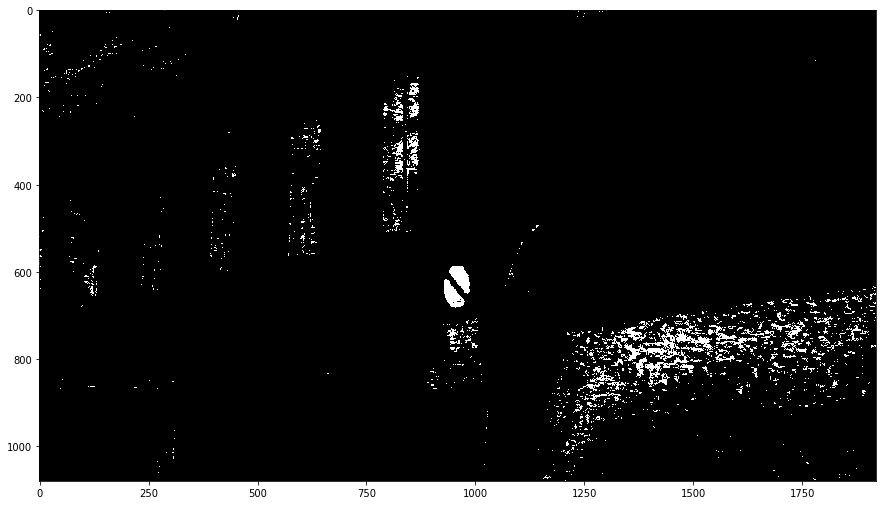

In [10]:
#blue with HSV thresholds
blue = detector.get_blue_image(img)
plt.figure(figsize=(15, 10))
plt.imshow(blue, cmap="gray")
print np.unique(blue)

array([  0, 255], dtype=uint8)

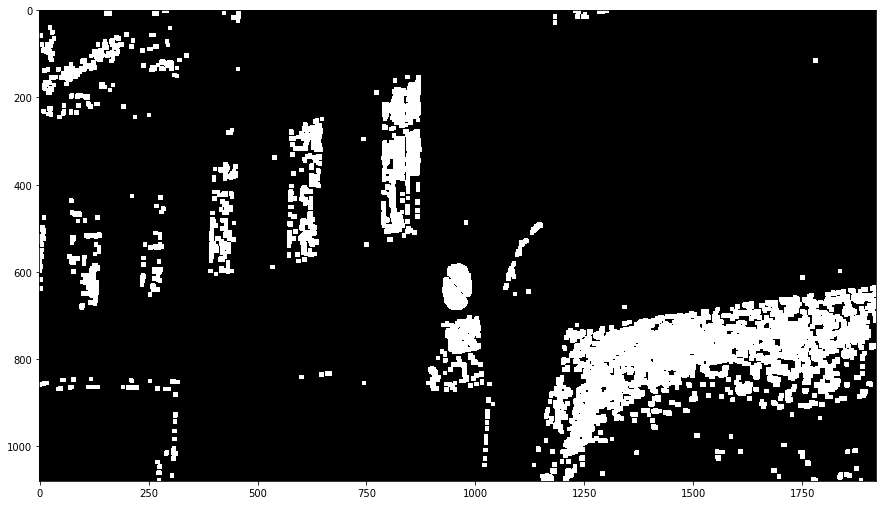

In [11]:
kernel = np.ones((10,10),np.uint8)
blue_dilated = cv2.dilate(blue, kernel)
plt.figure(figsize=(15, 10))
plt.imshow(blue_dilated, cmap="gray")
np.unique(blue_dilated)

array([0, 1], dtype=uint8)

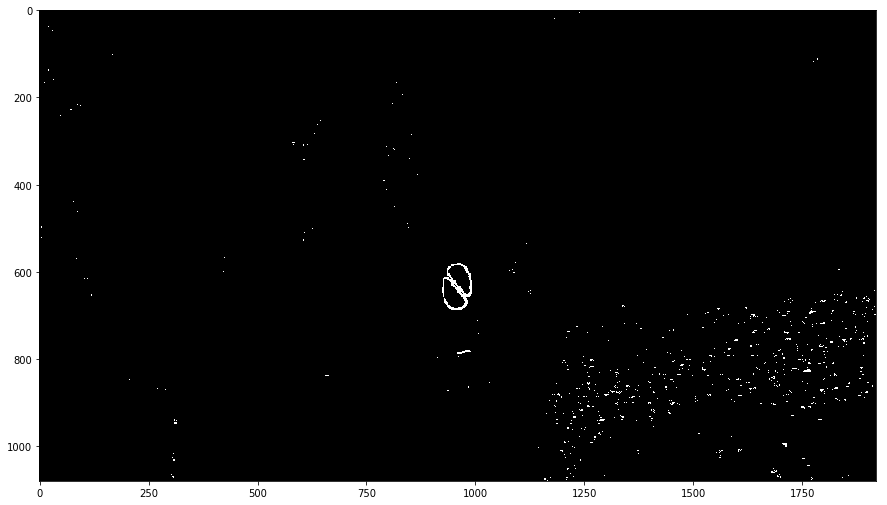

In [12]:
product = np.multiply(blue_dilated, red)
plt.figure(figsize=(15, 10))
plt.imshow(product, cmap="gray")
np.unique(product)